# Bucket Pricing

The main idea is to clean the distributions of the categories included in the data (each CategoryDesc will be considered as a different category), to create groups of similar categories using the **Kolmogorov-Smirnoff test**.

The, having groups of similar categories, create buckets for the ones that has not too much variance.

#  Libraries

In [1]:
library(ggplot2)
library(dplyr)
library(forcats)
library(readr)
library(factoextra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



# Read Data

In [2]:
data <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  primary_relation = col_double(),
  FiscalYear = col_double(),
  sold_price = col_double(),
  tax = col_double(),
  ItemID = col_double(),
  cost = col_double(),
  item_categorization = col_double(),
  Inventory_Days = col_double()
)

See spec(...) for full column specifications.

Warning message:
“1 parsing failure.
   row  col expected actual                                                                  file
386161 cost a double   NULL '/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data.csv'
”


In [3]:
data$date <- substr(data$origindate,1,10) %>% as.Date

Example of 1 row of the data

In [4]:
head(data,1) %>% t

[,1]                              
Country             USA                               
primary_relation    423090953                         
gid                 NULL                              
origindate          2020-05-16 15:15:13 +0000         
FiscalYear          2020                              
original_price      124.9899978637695                 
sold_price          81                                
tax                 0                                 
Item_ezid           180280165137                      
ItemID              480451189                         
cost                50                                
item_categorization 621003                            
Primary             General Merchandise               
Secondary           Tools                             
Tertiary            Power Tool                        
CategoryDesc        Circular Saw (No Special Features)
item_type           GM                                
store               18028                             
transType           Sales                             
customerType        No Customer                       
Inventory_Days      201                               
Manufacturer        PORTER-CABLE                      
Model_Number        324MAG                            
item_cond           A                                 
date                2020-05-16

# Cleaning  Data

## Drop big categories

The business wants buckets for "other stuff", so it will be dropped categories like:
 - TVs
 - Videogames
 - Tablets
 - Cellphones
 - Laptop

In [5]:
x <- c(
'Video Game Console',
'Laptop',
'LED',
'Digital OLED TVs',
'LCD',
'Tablet',
'Smart Phones',
'Cellular Telephone',
'NULL')

In [6]:
data %>%
 filter(!(CategoryDesc %in% x)) -> data

## Sold price > 5 dlls

For the business, every item sold <= 5 dlls has no importance, so will be filtered

In [7]:
data %>%
 filter(sold_price > 5) -> data

## 90B

Keep just items with ItemCondition B, sold in the first 90 days (without disccount), to be comparable

In [8]:
data %>%
 filter(item_cond == 'B',
        Inventory_Days <= 90) -> data

## LTV filter

Just items with LTV between 20% and 80%

In [9]:
data %>%
 mutate(LTV = cost/sold_price) %>%
 filter(LTV >= 0.2, LTV <= 0.8) -> data

## 50 items

To have reasonable distributions, only will be considered CategoryDesc with at least 50 items

In [10]:
l <- nrow(data)
uc <- unique(data$CategoryDesc) %>% length

paste0('The original data has ', scales::comma(l), ' rows, with ', uc, ' different CategoryDesc')

[1] "The original data has 320,147 rows, with 875 different CategoryDesc"

In [11]:
data %>%
 group_by(CategoryDesc) %>%
 mutate(n = n()) %>%
 filter(n >= 50) %>%
 select(-n) -> data

In [12]:
l <- nrow(data)
uc <- unique(data$CategoryDesc) %>% length

paste0('The data with representative CategoryDesc has ', scales::comma(l), ' rows, with ', uc, ' different CategoryDesc')

[1] "The data with representative CategoryDesc has 313,990 rows, with 447 different CategoryDesc"

## Drop outliers

Left and right outliers will be dropped, considering only the distribution between the 10 and 90 quantiles

In [13]:
data %>%
 group_by(CategoryDesc) %>%
 mutate(lim_inf = quantile(sold_price, 0.1),
        lim_sup = quantile(sold_price, 0.9)) %>%
 ungroup %>%
 filter(sold_price > lim_inf, sold_price < lim_sup) %>%
 select(-lim_inf, -lim_sup) -> data

# KS Test

Calculate the **Kolmogorov-Smirnoff p-value** for each combination of CategoryDesc

Create a data frame with all possible combinations of Category Desc

In [14]:
cd <- unique(data$CategoryDesc)

In [15]:
expand.grid.unique <- function(x, y, include.equals=FALSE)
{
    x <- unique(x)

    y <- unique(y)

    g <- function(i)
    {
        z <- setdiff(y, x[seq_len(i-include.equals)])

        if(length(z)) cbind(x[i], z, deparse.level=0)
    }

    do.call(rbind, lapply(seq_along(x), g))
}

In [16]:
expand.grid.unique(cd,cd) %>%
 as.data.frame %>%
 mutate(V1 = as.character(V1),
        V2 = as.character(V2)) -> comb

In [17]:
comb$ks <- NA

In [18]:
options(warn=-1)
for(i in 1:nrow(comb)){
    cat1 <- comb$V1[i]
    cat2 <- comb$V2[i]
    
    data %>%
     filter(CategoryDesc == cat1) %>%
     select(sold_price) %>%
     pull -> d1
    
    data %>%
     filter(CategoryDesc == cat2) %>%
     select(sold_price) %>%
     pull -> d2
    
    ks <- ks.test(d1,d2)
    
    comb$ks[i] <- ks$p.value
    
    
}

In [19]:
setwd('/Users/darias/Documents/Bucket_Pricing/Data_Out/')

In [20]:
write.csv(comb,file = 'CategoryDesc_ks.csv',row.names = FALSE)

In [21]:
#comb <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data_Out/CategoryDesc_ks.csv')

## Example of similar distributions

In [22]:
comb %>% filter(ks >= 0.05) %>% filter(V1 == 'Cordless Drill')

V1             V2                                 ks        
1  Cordless Drill CB Radio                           0.42307288
2  Cordless Drill Foot Pedal                         0.17414745
3  Cordless Drill Fitness Trackers                   0.25282770
4  Cordless Drill Car Stereo Accessory               0.10631749
5  Cordless Drill Cordless Hedge Trimmer             0.30487782
6  Cordless Drill Corded Scroll Saws                 0.20865856
7  Cordless Drill Crash Cymbals                      0.10422810
8  Cordless Drill T-Nail Gun                         0.05476775
9  Cordless Drill Yard Vacuum                        0.45583278
10 Cordless Drill Component System                   0.26600817
11 Cordless Drill Reflecting Telescope               0.17869195
12 Cordless Drill Ukulele                            0.06067518
13 Cordless Drill Drill Press                        0.39077048
14 Cordless Drill Equalizer Component                0.19711618
15 Cordless Drill Range Top Microwave                0.47497749
16 Cordless Drill Car Stereo Disc Changer            0.06785064
17 Cordless Drill Midi Foot / Pedalboard Controllers 0.17510722
18 Cordless Drill Karaoke Machine                    0.10054395
19 Cordless Drill Cordless Right-Angle Drill         0.05145258
20 Cordless Drill Universal Gym                      0.07737813
21 Cordless Drill Riding Boots                       0.31171772
22 Cordless Drill Inspection Camera                  0.16417561
23 Cordless Drill Gas Grill                          0.19801528
24 Cordless Drill Rangefinders                       0.05031615

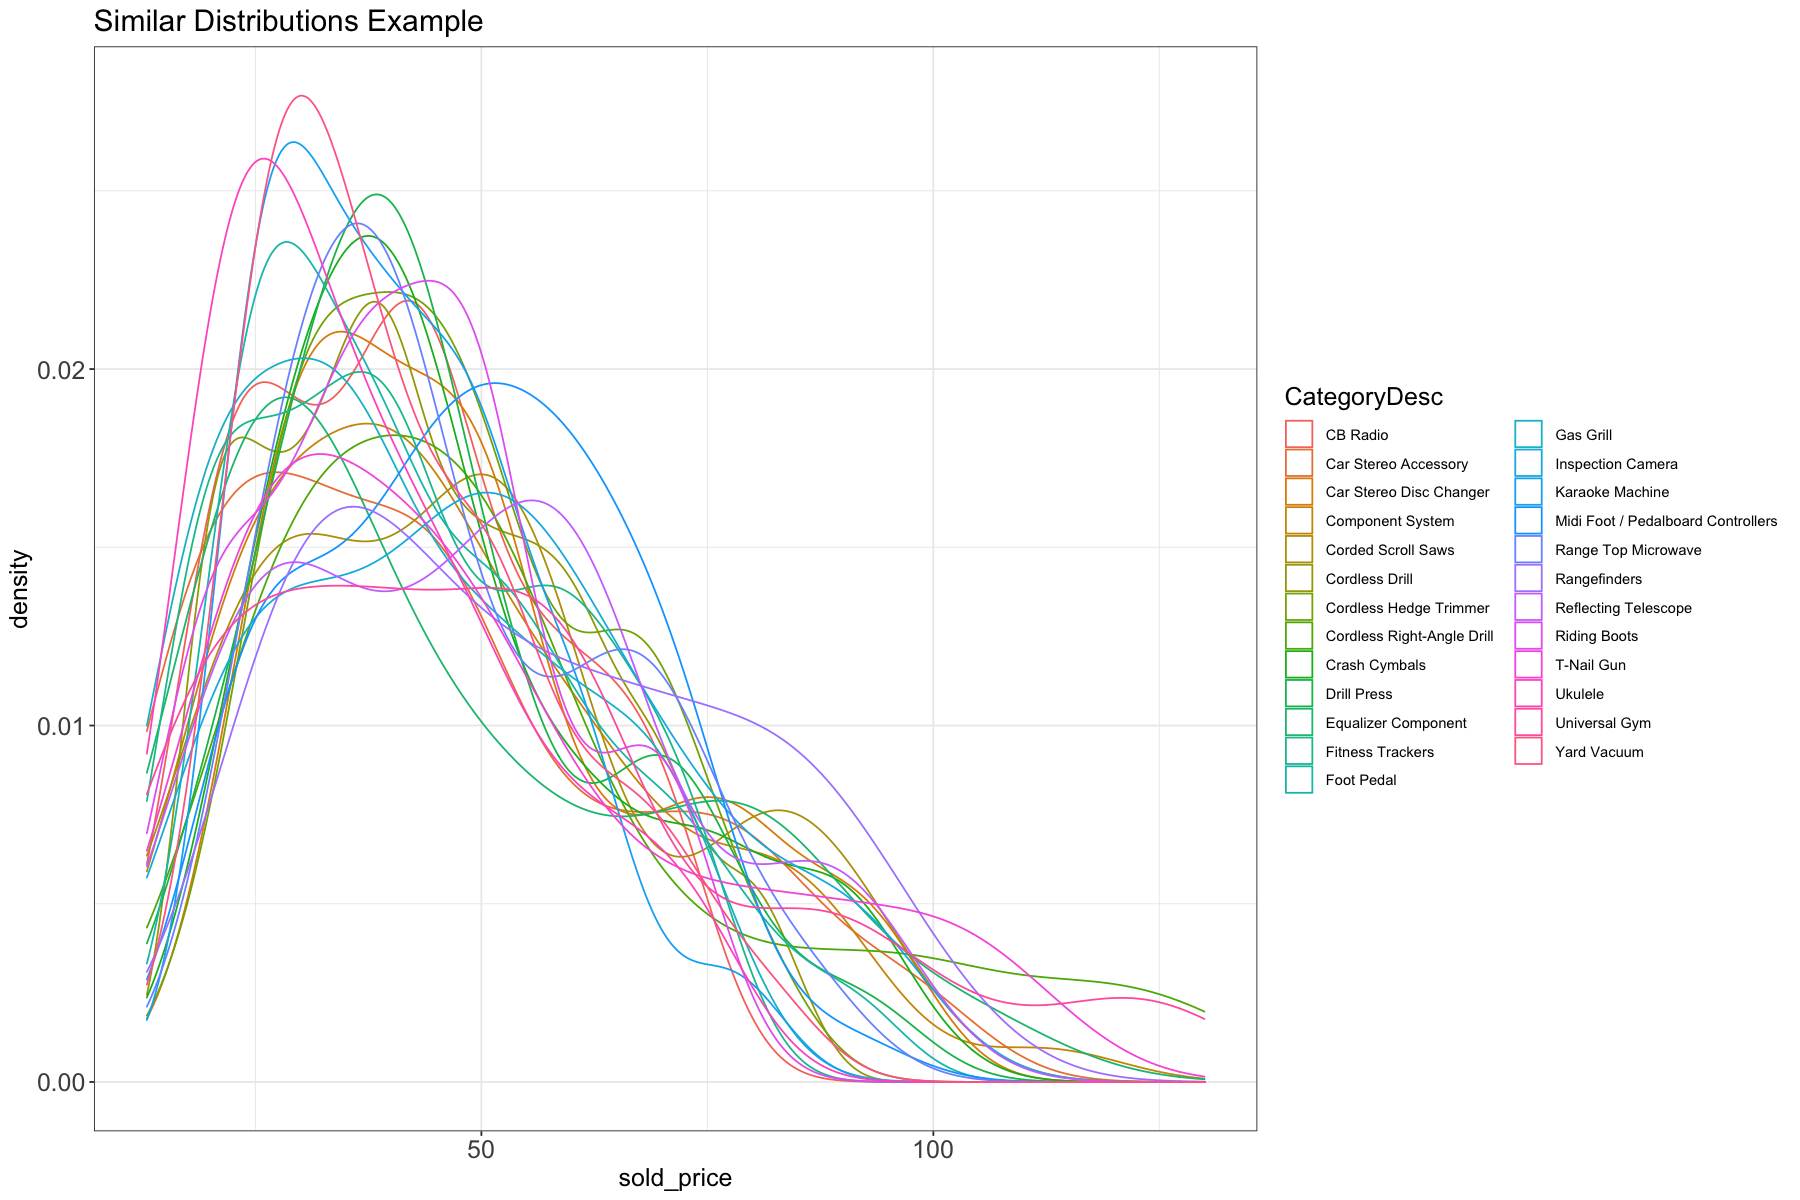

In [23]:
options(repr.plot.width=15, repr.plot.height=10)

a <- c('Cordless Drill',comb %>%
                         filter(ks >= 0.05) %>%
                         filter(V1 == 'Cordless Drill') %>% select(V2) %>% pull)

data %>%
 filter(CategoryDesc %in% a) %>%
 ggplot() +
 geom_density(aes(sold_price, colour = CategoryDesc), alpha = 0.2) +
 theme_bw() +
 ggtitle('Similar Distributions Example') +
 theme(axis.text.x  = element_text(size = 15),
       axis.text.y  = element_text(size = 15),
       axis.title.x = element_text(size = 15),
       axis.title.y = element_text(size = 15),
       title        = element_text(size = 15))

## Groups

Create groups using similar distributions

In [24]:
cats <- unique(c(comb$V1,comb$V2))

In [25]:
data.frame(CategoryDesc = NA,
           Group        = NA,
           Reference    = NA)  %>%
 filter(!is.na(NA)) -> groups

In [26]:
for(i in 1:length(cats)){    
    if(i == 1){
        
        aux1 <- comb %>% filter(V1 == cats[i],ks >= 0.05) %>% select(V2) %>% pull
        aux2 <- comb %>% filter(V2 == cats[i],ks >= 0.05) %>% select(V1) %>% pull
        g   <- c(cats[i], aux1, aux2)
        data.frame(CategoryDesc = g,
                   Group        = 1,
                   Reference    = cats[i]) -> df_aux
        
        } else {
        
        if(!(cats[i] %in% groups$CategoryDesc)){
            
            aux1 <- comb %>% filter(V1 == cats[i],ks >= 0.05) %>% select(V2) %>% pull
            aux2 <- comb %>% filter(V2 == cats[i],ks >= 0.05) %>% select(V1) %>% pull
            g   <- c(cats[i], aux1, aux2)
            last_group <- max(groups$Group)
            data.frame(CategoryDesc = g,
                       Group        = 1+last_group,
                       Reference    = cats[i]) -> df_aux
            
        }

    }
    
    groups <- rbind(groups,df_aux)
}

In [27]:
groups %>%
 distinct -> groups

In [28]:
groups %>% head

CategoryDesc           Group Reference     
1 Cordless Drill         1     Cordless Drill
2 CB Radio               1     Cordless Drill
3 Foot Pedal             1     Cordless Drill
4 Fitness Trackers       1     Cordless Drill
5 Car Stereo Accessory   1     Cordless Drill
6 Cordless Hedge Trimmer 1     Cordless Drill

## Solve Ties

Assign Categories in more than one group, to the most similar group.

This will be done calculating the average KS p-value for each CategoryDesc in more than 1 group, versus all the CategoryDesc in each group, and it will be assigned in the group with the highest p-value average

In [29]:
groups %>%
 group_by(CategoryDesc) %>%
 tally %>%
 filter(n > 1) %>%
 select(CategoryDesc) %>%
 pull -> reps

num_groups <- max(groups$Group)

In [30]:
for(i in 1:length(reps)){
    options(warn=-1)
    cat_rep <- reps[i]
    
    data.frame(cluster = NA,
               avg_ks  = NA) %>%
     filter(!is.na(cluster)) -> df
    
    for(j in 1:num_groups){
        categ     <- groups %>% filter(Group == j) %>% select(CategoryDesc) %>% pull
        num_categ <- length(categ)
        
        kss <- NA
        for(k in 1:num_categ){
            dist1 <- data %>% filter(CategoryDesc == categ[k]) %>% select(sold_price) %>% pull
            dist2 <- data %>% filter(CategoryDesc == cat_rep) %>% select(sold_price) %>% pull
            
            ks_p <- ks.test(dist1,dist2)
            
            kss <- c(kss,ks_p$p.value)
        }
        
        data.frame(cluster = j,
                   avg_ks  = mean(kss,na.rm = TRUE)) -> aux
        
        df <- rbind(df,aux)
    }
    
    
    df %>%
     arrange(desc(avg_ks)) %>%
     head(1) %>%
     select(cluster) %>%
     pull -> opt_cluster
    
    groups %>%
     filter(CategoryDesc != cat_rep) -> groups
    
    groups %>%
     filter(Group == opt_cluster) %>%
     select(Reference) %>%
     head(1) -> Ref
    
    data.frame(CategoryDesc = cat_rep,
               Group        = opt_cluster,
               Reference    = Ref) -> aux2
    
    groups <- rbind(groups, aux2) %>% arrange(Group)
    
}

In [31]:
write.csv(groups,file = 'groups_ks.csv',row.names = FALSE)

Add the groups in all the data

In [32]:
data %>%
 left_join(groups, by = 'CategoryDesc') -> data

In [33]:
length(unique(groups$Group))

[1] 111

## Example similar Distributions

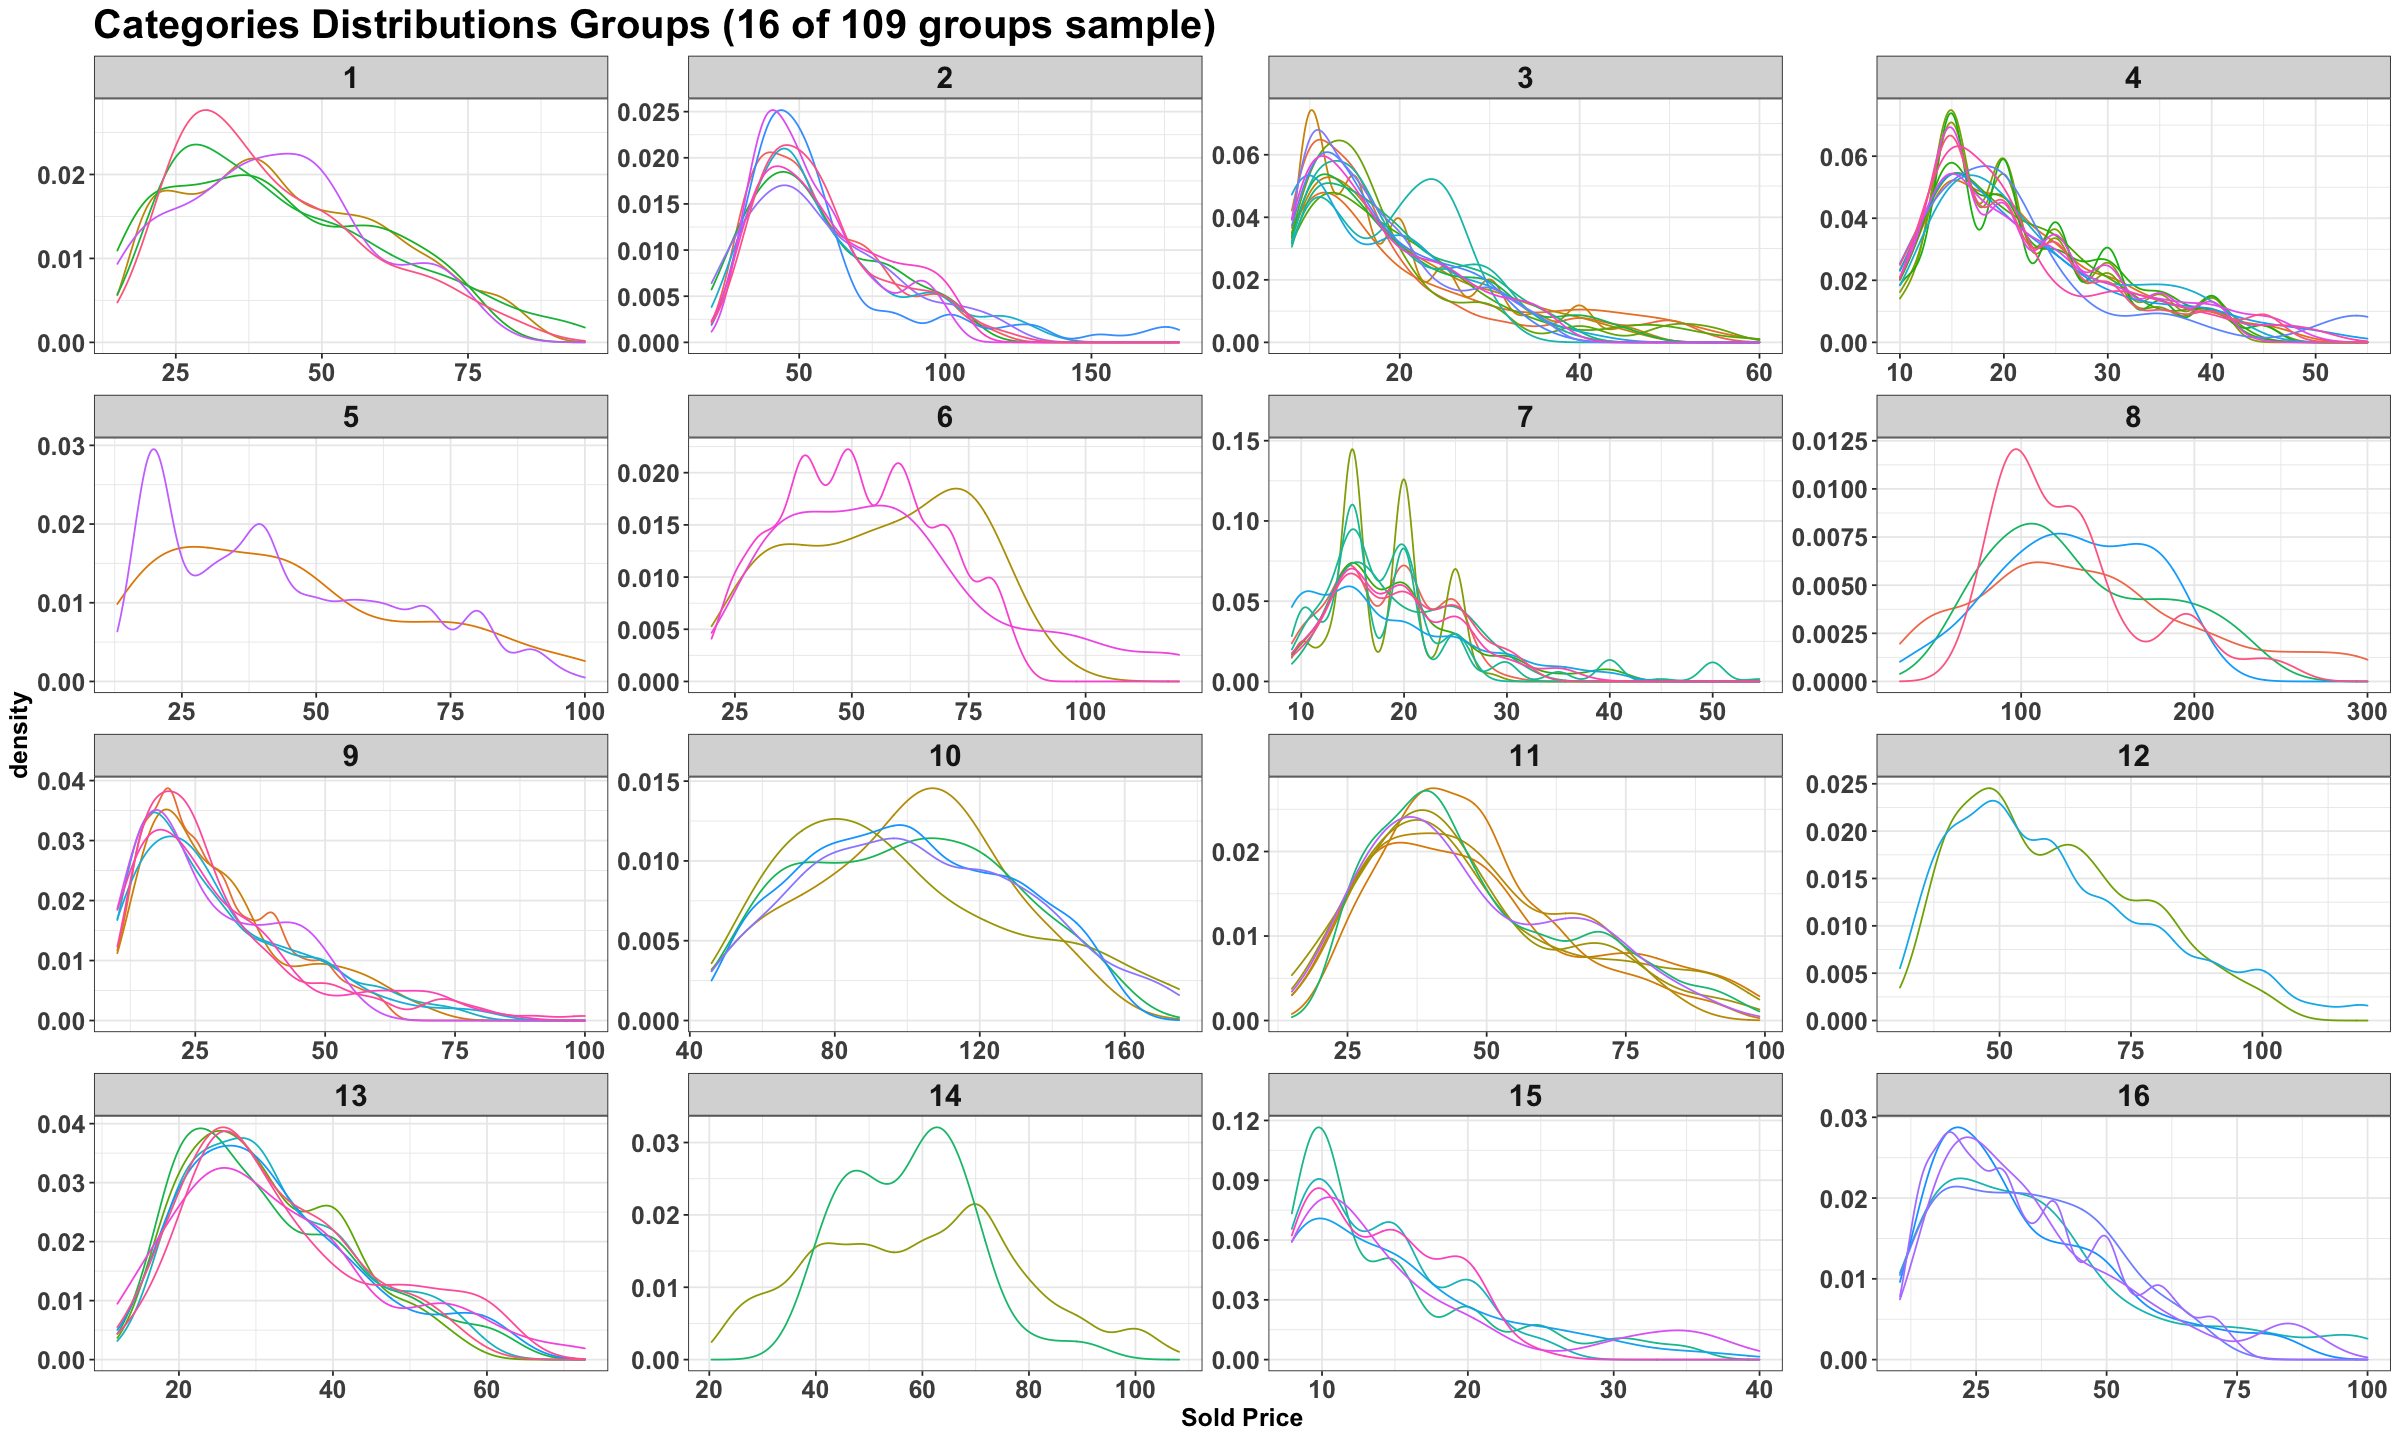

In [34]:
options(repr.plot.width=20, repr.plot.height=12)

data %>%
 filter(Group <= 16) %>%
 ggplot() +
 geom_density(aes(sold_price, colour = CategoryDesc)) +
 theme_bw() +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       legend.position = 'none',
       strip.text.x    = element_text(size = 18, face = 'bold')) +
 facet_wrap(~Group, scales = 'free') +
 ggtitle('Categories Distributions Groups (16 of 109 groups sample)') +
 xlab('Sold Price')
 

# Write data

Write item level data, with the group

In [35]:
getwd()

[1] "/Users/darias/Documents/Bucket_Pricing/Data_Out"

In [36]:
write.csv(data %>% select(-Reference), file = 'Item_Groups_Distribution.csv', row.names = FALSE)

In [37]:
tail(groups)

CategoryDesc               Group Reference              
442 4K                         109   4K                     
443 Basic Blu-ray DVD Movie    110   Basic Blu-ray DVD Movie
444 Electric RC Car            111   Electric RC Car        
445 DJ Controllers             111   Electric RC Car        
446 Acoustic 12 String Guitars 111   Electric RC Car        
447 Laser Transit              111   Electric RC Car

# Analysing right tail

Analyze if for the cluster 2, as an example, the right tail is because some items that really has high prices, or are employees errors

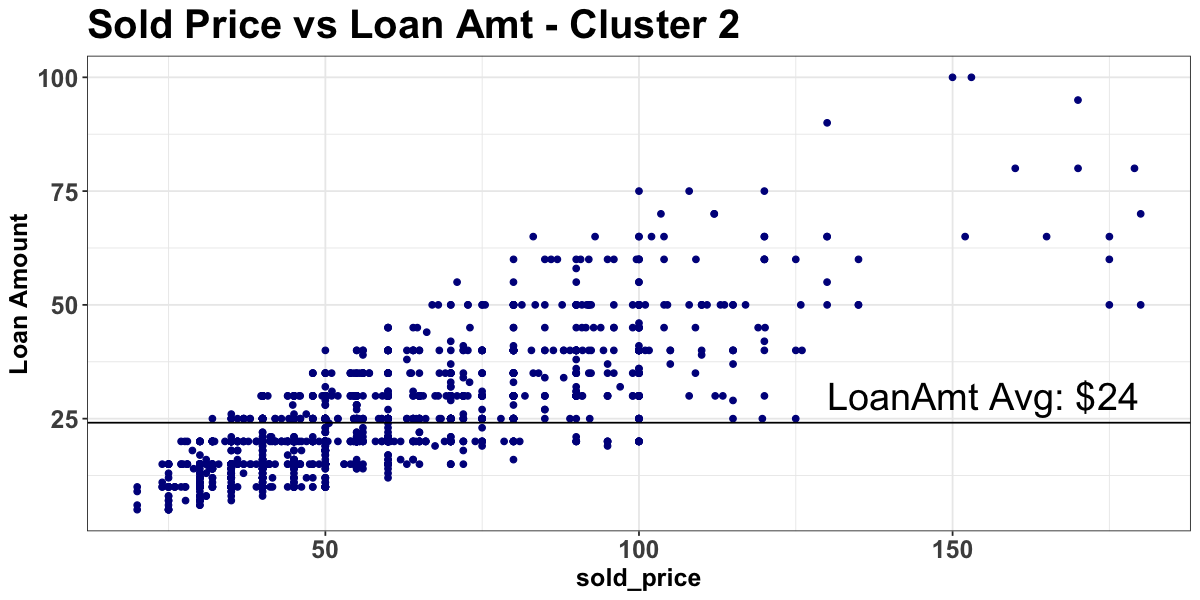

In [54]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(Group == 2) %>%
 select(cost) %>%
 pull %>%
 mean -> lam

data %>%
 filter(Group == 2) %>%
 ggplot() +
 geom_point(aes(x = sold_price, y = cost), colour = 'darkblue') +
 ggtitle('Sold Price vs Loan Amt - Cluster 2') +
 theme_bw() +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       legend.position = 'none',
       strip.text.x    = element_text(size = 18, face = 'bold')) +
 ylab('Loan Amount') +
 geom_hline(yintercept = lam) +
 annotate(geom  = 'text',
          x     = 130,
          y     = lam,
          label = paste0('LoanAmt Avg: $', round(lam)),
          vjust = -0.5,
          hjust = 0,
          size  = 8)

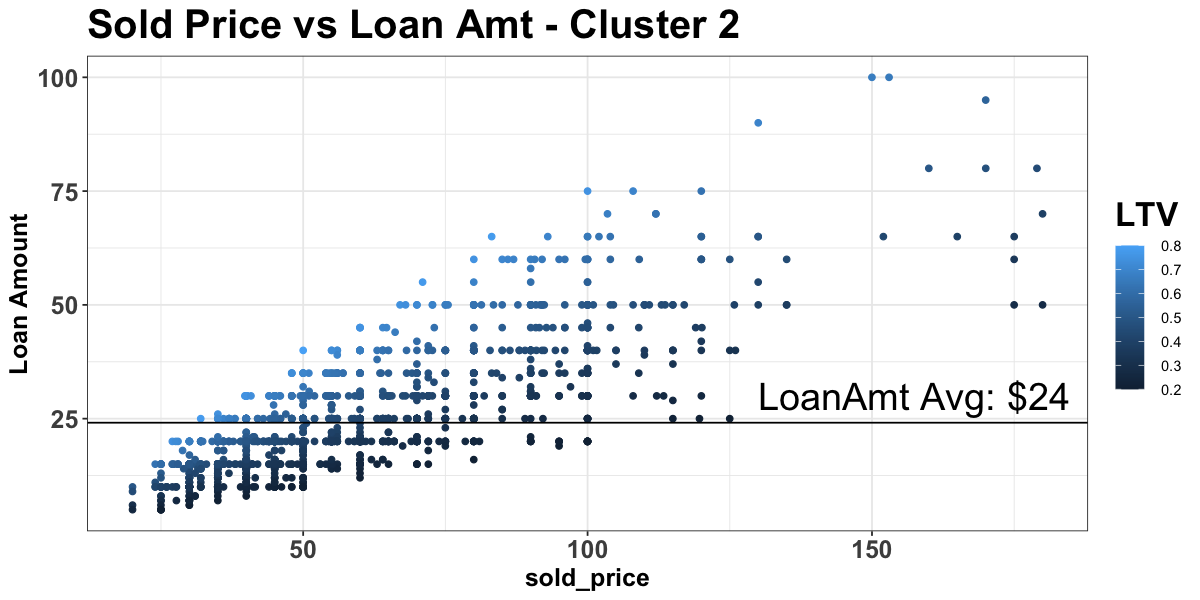

In [63]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(Group == 2) %>%
 select(cost) %>%
 pull %>%
 mean -> lam

data %>%
 filter(Group == 2) %>%
 ggplot() +
 geom_point(aes(x = sold_price, y = cost, colour = LTV)) +
 ggtitle('Sold Price vs Loan Amt - Cluster 2') +
 theme_bw() +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold')) +
 ylab('Loan Amount') +
 geom_hline(yintercept = lam) +
 annotate(geom  = 'text',
          x     = 130,
          y     = lam,
          label = paste0('LoanAmt Avg: $', round(lam)),
          vjust = -0.5,
          hjust = 0,
          size  = 8)

In [61]:
data %>%
 filter(Group == 2,
        cost  >= lam,
        sold_price >= 110) %>%
 select(Item_ezid,ItemID,Secondary,Tertiary,CategoryDesc,Manufacturer,Model_Number,
        sold_price,cost) %>%
 head

Item_ezid    ItemID    Secondary           Tertiary              
1 012516112965 514224638 Tools               Power Tool            
2 011680496705 515895575 Tools               Power Tool            
3 011590864881 523373743 Sporting Goods      Other                 
4 040230652815 497036087 Sporting Goods      Other                 
5 030070965231 534452726 Electronics         Home Stereo           
6 180220162302 522848648 Musical Instruments Electronic Accessories
  CategoryDesc             Manufacturer Model_Number sold_price cost
1 Pole Saw                 POULAN       PP28         129.99     65  
2 Pole Saw                 ECHO         PPT-260      130.00     90  
3 Metal Detectors          TEKNETICS    DELTA4000    119.99     75  
4 Metal Detectors          BOUNTYHUNTER LAND RANGER  125.99     40  
5 AM/FM Receiver Component NULL         NULL         119.67     25  
6 Processor                NULL         NULL         112.00     70